In [1]:
# Step 0: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 2: Load Dataset from Drive
file_path = '/content/drive/MyDrive/heartAttack_cleaned.csv'  # Change path if needed
df = pd.read_csv(file_path)
print("Dataset loaded. Shape:", df.shape)
print("Target distribution:\n", df['heart_attack'].value_counts())
df.head()

Dataset loaded. Shape: (120255, 28)
Target distribution:
 heart_attack
0.0    94855
1.0    25400
Name: count, dtype: int64


,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60.0,male,rural,middle,0.0,1.0,198.0,0.0,83.0,0.0,...,62.0,173.0,48.0,121.0,101.0,normal,0.0,0.0,0.0,0.0
1,53.0,female,urban,low,0.0,0.0,208.0,0.0,106.0,1.0,...,76.0,70.0,58.0,83.0,138.0,normal,1.0,0.0,1.0,0.0
2,62.0,female,urban,low,0.0,0.0,231.0,1.0,112.0,1.0,...,74.0,118.0,69.0,130.0,171.0,abnormal,0.0,1.0,0.0,1.0
3,73.0,male,urban,low,1.0,0.0,202.0,0.0,82.0,1.0,...,65.0,98.0,52.0,85.0,146.0,normal,0.0,1.0,1.0,0.0
4,52.0,male,urban,middle,0.0,0.0,231.0,1.0,81.0,1.0,...,71.0,129.0,34.0,148.0,191.0,normal,0.0,1.0,1.0,0.0


In [4]:
# Step 3: Separate Features and Target
y = df['heart_attack']
X = df.drop('heart_attack', axis=1)

In [6]:
# Step 4: Handle Categorical Columns (One-Hot Encoding)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", categorical_cols)
if categorical_cols:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, prefix=categorical_cols)
    print("After one-hot encoding, feature shape:", X_encoded.shape)
else:
    X_encoded = X.copy()

Categorical columns: ['gender', 'region', 'income_level', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'stress_level', 'EKG_results']
After one-hot encoding, feature shape: (120255, 43)


In [7]:
# Step 5: Split Data BEFORE Any Feature Selection (Avoid Data Leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (96204, 43), Test shape: (24051, 43)


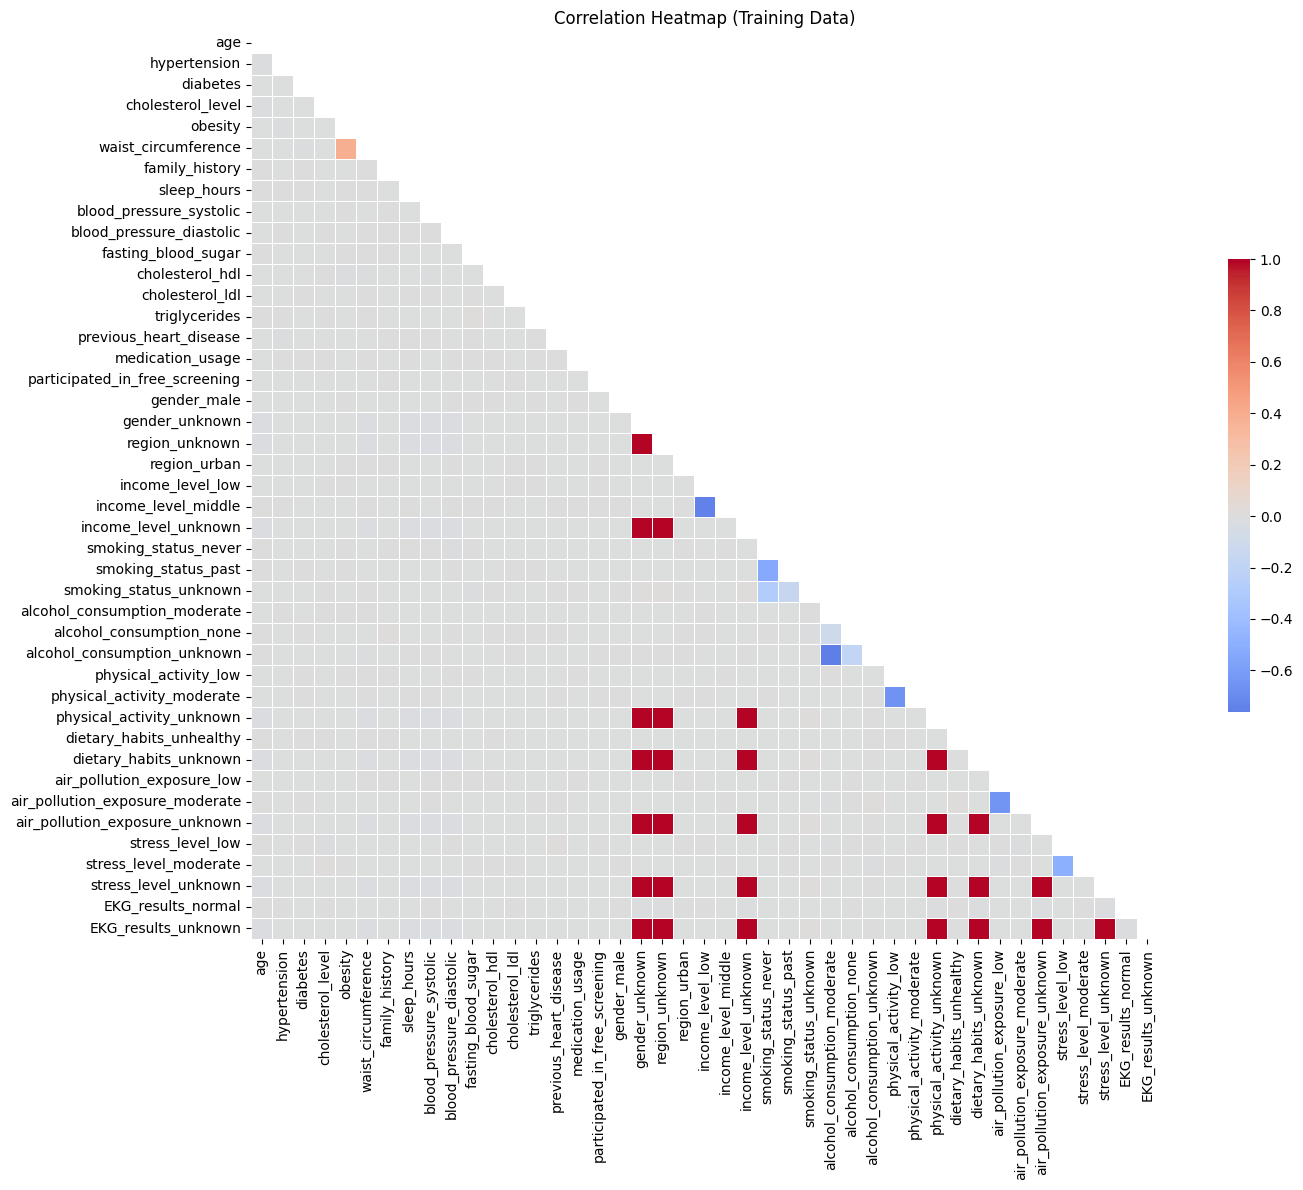

In [8]:
# Step 6: Correlation Check and Drop Highly Correlated Features (on Training Data Only)
plt.figure(figsize=(16, 12))
corr = X_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap (Training Data)")
plt.tight_layout()
plt.show()

In [9]:
# Drop features with correlation > 0.85 (on training data)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.85)]
print("Highly correlated features to drop:", to_drop)

Highly correlated features to drop: ['region_unknown', 'income_level_unknown', 'physical_activity_unknown', 'dietary_habits_unknown', 'air_pollution_exposure_unknown', 'stress_level_unknown', 'EKG_results_unknown']


In [11]:
X_train_reduced = X_train.drop(columns=to_drop, errors='ignore')
X_test_reduced = X_test.drop(columns=to_drop, errors='ignore')
print(f"After correlation removal - Train: {X_train_reduced.shape}, Test: {X_test_reduced.shape}")

After correlation removal - Train: (96204, 36), Test: (24051, 36)


In [12]:
# Step 7: Univariate Feature Selection (Top 15 on Training Data Only)
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_reduced, y_train)
selected_features = X_train_reduced.columns[selector.get_support()]
print("Top 15 features (univariate selection):", selected_features.tolist())

Top 15 features (univariate selection): ['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'fasting_blood_sugar', 'previous_heart_disease', 'medication_usage', 'region_urban', 'smoking_status_never', 'smoking_status_past', 'alcohol_consumption_unknown', 'stress_level_moderate', 'EKG_results_normal']


Top 15 features (univariate selection): ['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'fasting_blood_sugar', 'previous_heart_disease', 'medication_usage', 'region_urban', 'smoking_status_never', 'smoking_status_past', 'alcohol_consumption_unknown', 'stress_level_moderate', 'EKG_results_normal']


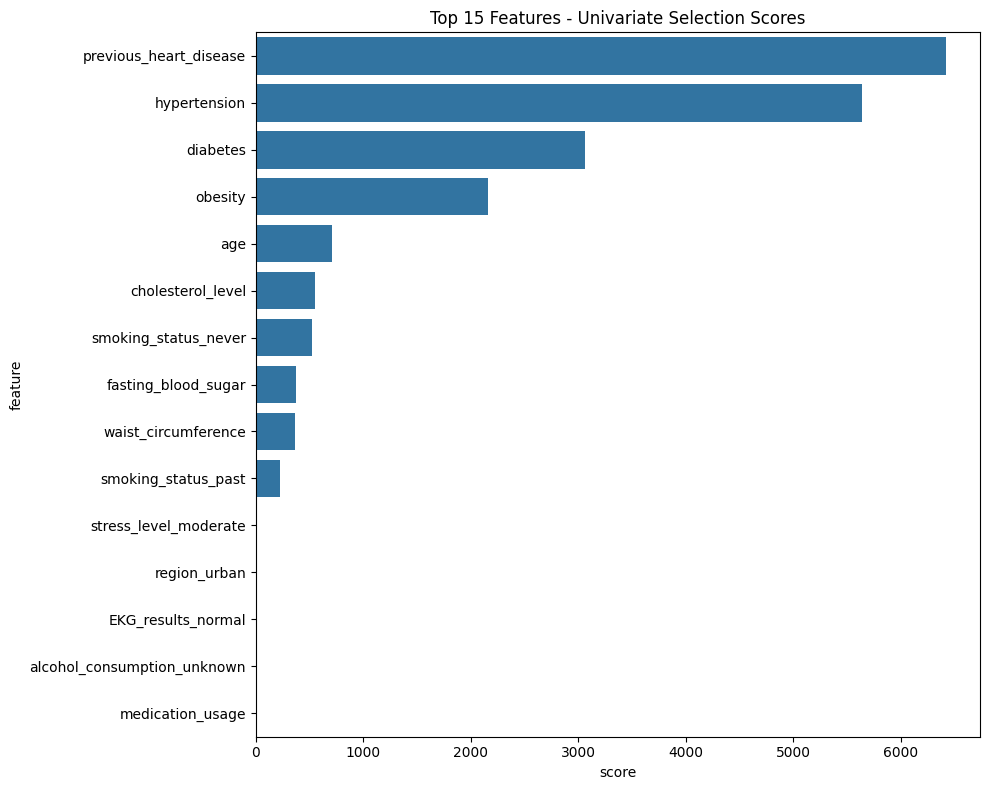

In [14]:
# Step 7: Univariate Feature Selection (Top 15 on Training Data Only)
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_reduced, y_train)
selected_features = X_train_reduced.columns[selector.get_support()]
print("Top 15 features (univariate selection):", selected_features.tolist())

# Get scores for visualization
feature_scores = pd.DataFrame({
    'feature': X_train_reduced.columns,
    'score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('score', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_scores.head(15), x='score', y='feature')
plt.title("Top 15 Features - Univariate Selection Scores")
plt.tight_layout()
plt.show()

In [16]:
# Apply selection to test set
X_test_selected = X_test_reduced[selected_features]

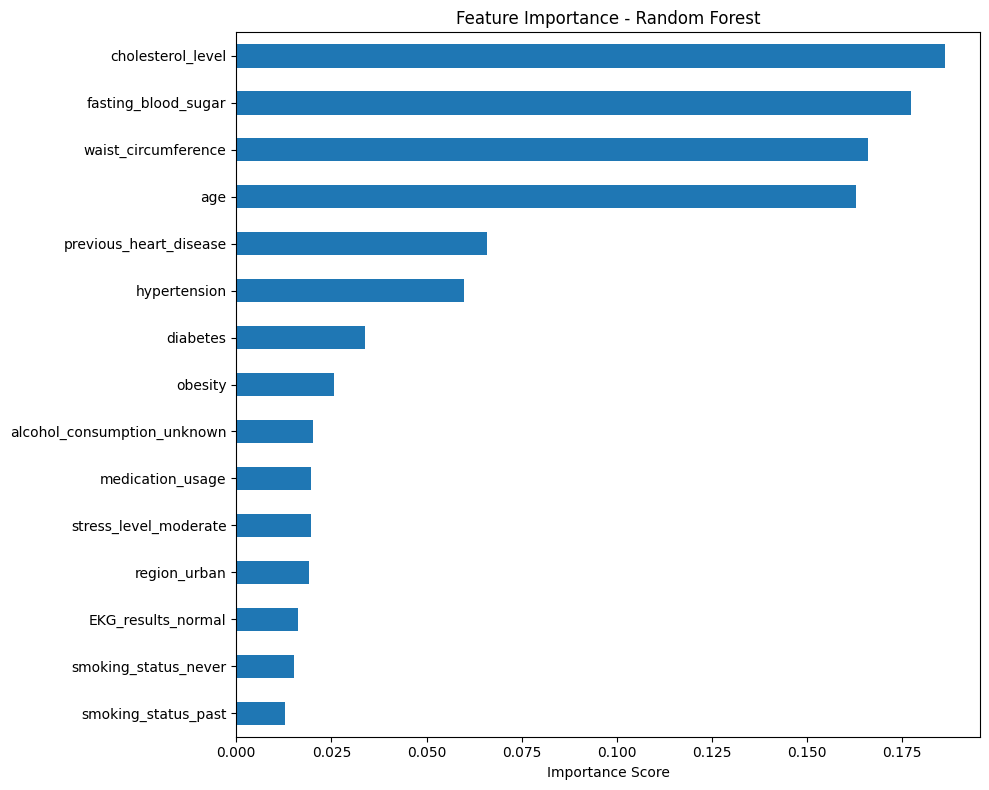

In [17]:
# Step 8: Model-Based Feature Importance (Random Forest on Selected Features)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_selected, y_train)

importances = pd.Series(model_rf.feature_importances_, index=selected_features)
importances_sorted = importances.sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances_sorted.plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [19]:
# Keep features with importance > 0.02
important_features = importances[importances > 0.02].index
print(f"Features with importance > 0.02 ({len(important_features)}):", important_features.tolist())
if len(important_features) == 0:
    print("No features passed importance threshold. Using top 8 features.")
    important_features = importances.nlargest(8).index

X_train_final = X_train_selected[important_features] if isinstance(X_train_selected, pd.DataFrame) else pd.DataFrame(X_train_selected, columns=selected_features)[important_features]
X_test_final = X_test_selected[important_features]

print(f"Final feature set - Train: {X_train_final.shape}, Test: {X_test_final.shape}")

Features with importance > 0.02 (9): ['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'fasting_blood_sugar', 'previous_heart_disease', 'alcohol_consumption_unknown']
Final feature set - Train: (96204, 9), Test: (24051, 9)


In [20]:
# Step 9: Feature Scaling (Using RobustScaler to Handle Outliers)
scaler = RobustScaler()  # Better for real-world data with outliers

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final),
    columns=X_train_final.columns,
    index=X_train_final.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index
)

print("Scaling completed using RobustScaler")


Scaling completed using RobustScaler


In [21]:
# Step 10: Safe Skewness Correction (Handle Negative Values)
def safe_skewness_correction(X_data):
    """Apply safe log transformation only to positively skewed features"""
    X_corrected = X_data.copy()

    for feature in X_corrected.columns:
        skewness = X_corrected[feature].skew()

        # Only correct highly skewed features (|skew| > 1)
        if abs(skewness) > 1:
            # Check if data has negative values
            min_val = X_corrected[feature].min()

            if min_val <= 0:
                # Shift to positive range for log transformation
                shift_value = abs(min_val) + 1  # +1 to avoid log(0)
                X_corrected[feature] = X_corrected[feature] + shift_value
                print(f"Shifted {feature} by {shift_value:.2f} to make positive")

            # Apply log transformation
            X_corrected[feature] = np.log1p(X_corrected[feature])
            print(f"Applied log transformation to {feature} (skewness: {skewness:.2f} -> {X_corrected[feature].skew():.2f})")

    return X_corrected

In [22]:
# Apply skewness correction to training data
X_train_corrected = safe_skewness_correction(X_train_scaled)

Shifted hypertension by 1.00 to make positive
Applied log transformation to hypertension (skewness: 1.15 -> 1.15)
Shifted diabetes by 1.00 to make positive
Applied log transformation to diabetes (skewness: 1.75 -> 1.75)
Shifted obesity by 1.00 to make positive
Applied log transformation to obesity (skewness: 1.35 -> 1.35)
Shifted previous_heart_disease by 1.00 to make positive
Applied log transformation to previous_heart_disease (skewness: 1.89 -> 1.89)


In [23]:
# Apply same transformation to test data (using training min values)
X_test_corrected = X_test_scaled.copy()
for feature in X_test_corrected.columns:
    if feature in X_train_scaled.columns:
        train_skew = X_train_scaled[feature].skew()
        if abs(train_skew) > 1:
            train_min = X_train_scaled[feature].min()
            if train_min <= 0:
                shift_value = abs(train_min) + 1
                X_test_corrected[feature] = X_test_corrected[feature] + shift_value
            X_test_corrected[feature] = np.log1p(X_test_corrected[feature])

print("Skewness correction completed")

Skewness correction completed


In [24]:
# Step 11: Feature Engineering (Only if original features exist)
def create_new_features(X_data, original_df, train_indices=None):
    """Create new features if original columns exist"""
    X_new = X_data.copy()

    # Check if we have access to original features
    if train_indices is not None and hasattr(original_df, 'iloc'):
        # For training data
        original_subset = original_df.iloc[train_indices]
    else:
        # For test data or general case
        original_subset = original_df

        # Create cholesterol to age ratio if columns exist
        if all(col in original_subset.columns for col in ['cholesterol_level', 'age']):
          X_new['cholesterol_age_ratio'] = original_subset['cholesterol_level'] / (original_subset['age'] + 1)
          print("Created 'cholesterol_age_ratio' feature")
        # Create blood pressure risk score if columns exist
        if all(col in original_subset.columns for col in ['blood_pressure_systolic', 'blood_pressure_diastolic']):
          X_new['bp_risk_score'] = (original_subset['blood_pressure_systolic'] - 120) + (original_subset['blood_pressure_diastolic'] - 80)
          print("Created 'bp_risk_score' feature")
        # Create health risk composite score
        risk_factors = []
        if 'hypertension' in original_subset.columns:
          risk_factors.append(original_subset['hypertension'])
        if 'diabetes' in original_subset.columns:
          risk_factors.append(original_subset['diabetes'])
        if 'smoking_status_current' in original_subset.columns:
          risk_factors.append(original_subset['smoking_status_current'])

        if risk_factors:
          X_new['risk_factors_count'] = sum(risk_factors)
          print("Created 'risk_factors_count' feature")

    return X_new


In [25]:
# Apply feature engineering
X_train_final = create_new_features(X_train_corrected, df, X_train.index)
X_test_final = create_new_features(X_test_corrected, df, X_test.index)

print(f"Final dataset shapes - Train: {X_train_final.shape}, Test: {X_test_final.shape}")

Final dataset shapes - Train: (96204, 9), Test: (24051, 9)


In [26]:
# Step 12: Add Target Back
train_final = X_train_final.copy()
test_final = X_test_final.copy()
train_final['heart_attack'] = y_train.values
test_final['heart_attack'] = y_test.values

In [28]:
# Step 13: Validate Final Dataset
print("\n=== FINAL DATASET VALIDATION ===")
print(f"Training set: {train_final.shape}")
print(f"Test set: {test_final.shape}")
print(f"Features: {list(train_final.columns)}")
print("\nData types:")
print(train_final.dtypes)
print("\nMissing values:")
print(train_final.isnull().sum())
print("\nBasic statistics:")
print(train_final.describe())


=== FINAL DATASET VALIDATION ===
Training set: (96204, 10)
Test set: (24051, 10)
Features: ['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'fasting_blood_sugar', 'previous_heart_disease', 'alcohol_consumption_unknown', 'heart_attack']

Data types:
age                            float64
hypertension                   float64
diabetes                       float64
cholesterol_level              float64
obesity                        float64
waist_circumference            float64
fasting_blood_sugar            float64
previous_heart_disease         float64
alcohol_consumption_unknown    float64
heart_attack                   float64
dtype: object

Missing values:
age                            0
hypertension                   0
diabetes                       0
cholesterol_level              0
obesity                        0
waist_circumference            0
fasting_blood_sugar            0
previous_heart_disease         0
alcohol_consumption_unk

In [29]:
# Check for negative values in final dataset
negative_counts = (train_final.select_dtypes(include=[np.number]) < 0).sum()
print("\nNegative values in final dataset:")
print(negative_counts[negative_counts > 0])


Negative values in final dataset:
age                            46172
cholesterol_level              43499
waist_circumference            47659
fasting_blood_sugar            47785
alcohol_consumption_unknown    40839
dtype: int64


In [31]:
# Step 14: Save Final Datasets to Drive
train_final_path = '/content/drive/MyDrive/heart_attack_train_final.csv'
test_final_path = '/content/drive/MyDrive/heart_attack_test_final.csv'
train_final.to_csv(train_final_path, index=False)
test_final.to_csv(test_final_path, index=False)

In [32]:
print(f"\nFinal datasets saved:")
print(f"Training: {train_final_path}")
print(f"Testing: {test_final_path}")


Final datasets saved:
Training: /content/drive/MyDrive/heart_attack_train_final.csv
Testing: /content/drive/MyDrive/heart_attack_test_final.csv


In [33]:
print(f"\nFinal datasets saved:")
print(f"Training: {train_final_path}")
print(f"Testing: {test_final_path}")


Final datasets saved:
Training: /content/drive/MyDrive/heart_attack_train_final.csv
Testing: /content/drive/MyDrive/heart_attack_test_final.csv


In [34]:
# Step 15: Create a Combined Dataset (Optional)
combined_final = pd.concat([train_final, test_final], axis=0)
combined_path = '/content/drive/MyDrive/heart_attack_combined_final.csv'
combined_final.to_csv(combined_path, index=False)
print(f"Combined dataset: {combined_path}")

Combined dataset: /content/drive/MyDrive/heart_attack_combined_final.csv


In [35]:
# Step 16: Download the Final Dataset
from google.colab import files
files.download(train_final_path)
files.download(test_final_path)
files.download(combined_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>